In [ ]:

# Step 1: Upload the zip file in Google Colab
from google.colab import files
uploaded = files.upload()


Saving data.zip to data.zip


In [ ]:

# Step 2: Unzip the file in Google Colab
import zipfile
import io

with zipfile.ZipFile(io.BytesIO(uploaded['data.zip']), 'r') as zip_ref:
    zip_ref.extractall('/content')  # Contents of zip file extracted in the root directory in Google Colab


In [ ]:

# Step 3: Sets up necessary paths, defines utility functions, processes images and annotations, and lists the first few lines of the processed data
import os
import cv2
import xml.etree.ElementTree as ET
import numpy as np
from tensorflow.keras.applications.resnet50 import preprocess_input

# Output statement
print("Setting up paths and folders...")

# Paths to data folders in Google Colab
images_folder = '/content/data/images/Images'
annotations_folder = '/content/data/annotations/Annotation'
output_folder = '/content/output'

# Create output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Output statement
print("Functions and folders setup completed.")

# Function to extract breed label from folder name
def extract_breed_label(folder_name):
    return folder_name.split('-')[-1].replace('_', ' ')

# Function to read annotation file and extract breed label
def read_annotation(annotation_file):
    try:
        tree = ET.parse(annotation_file)
        root = tree.getroot()
        for obj in root.findall('object'):
            breed_label = obj.find('name').text
            return breed_label
    except Exception as e:
        print(f"Error reading annotation file: {annotation_file}, Error: {e}")
        return None

# Function to resize images while maintaining aspect ratio
def resize_with_aspect_ratio(image, target_size):
    h, w = image.shape[:2]
    target_h, target_w = target_size

    # Calculate aspect ratios
    aspect_ratio = w / h
    target_aspect_ratio = target_w / target_h

    # Resize based on the aspect ratio
    if aspect_ratio > target_aspect_ratio:
        # Resize based on width
        new_w = target_w
        new_h = int(new_w / aspect_ratio)
    else:
        # Resize based on height
        new_h = target_h
        new_w = int(new_h * aspect_ratio)

    # Resize the image
    resized_image = cv2.resize(image, (new_w, new_h))
    return resized_image

# Output statement
print("Defined utility functions.")

# Lists to store original image dimensions
image_dimensions = []

# Output statement
print("Processing images and annotations...")

# Iterate over each annotation file in the annotations folder
for breed_folder in os.listdir(annotations_folder):
    breed_annotations_folder = os.path.join(annotations_folder, breed_folder)
    if os.path.isdir(breed_annotations_folder):
        breed_label = extract_breed_label(breed_folder)
        print(f"Processing annotations for folder: {breed_folder}, Breed label: {breed_label}")

        # Construct path to the images folder for the current breed
        breed_images_folder = os.path.join(images_folder, breed_folder)

        # Iterate over each image file in the breed folder
        for image_file in os.listdir(breed_images_folder):
            if image_file.endswith('.jpg') or image_file.endswith('.png'):
                # Get the corresponding annotation file path
                annotation_file = os.path.splitext(image_file)[0] + '.xml'
                annotation_file_path = os.path.join(breed_annotations_folder, annotation_file)

                # Read the image
                image_file_path = os.path.join(breed_images_folder, image_file)
                image = cv2.imread(image_file_path)

                # Preprocess the image using ResNet50 preprocess_input function
                preprocessed_image = preprocess_input(image)

                # Save the original image dimensions
                image_dimensions.append(preprocessed_image.shape)

                # Save the preprocessed image to the output folder
                breed_output_folder = os.path.join(output_folder, breed_label)
                if not os.path.exists(breed_output_folder):
                    os.makedirs(breed_output_folder)
                output_file = os.path.join(breed_output_folder, image_file)
                cv2.imwrite(output_file, preprocessed_image)  # Save preprocessed image

                # Output statement
                print(f"Processed image: {output_file}")

# Output statement
print("Image preprocessing completed.")

# Output statement
print("Sample of processed data:")

# List the first few lines of the processed data
for breed_folder in os.listdir(output_folder):
    breed_output_folder = os.path.join(output_folder, breed_folder)
    if os.path.isdir(breed_output_folder):
        print(f"Breed Label: {breed_folder}")
        for idx, image_file in enumerate(os.listdir(breed_output_folder)):
            if idx >= 3:  # Print only the first three images for brevity
                break
            print(f"  Image File: {image_file}")


Setting up paths and folders...
Functions and folders setup completed.
Defined utility functions.
Processing images and annotations...
Processing annotations for folder: n02087394-Rhodesian_ridgeback, Breed label: Rhodesian ridgeback
Processed image: /content/output/Rhodesian ridgeback/n02087394_3048.jpg
Processed image: /content/output/Rhodesian ridgeback/n02087394_4459.jpg
Processed image: /content/output/Rhodesian ridgeback/n02087394_514.jpg
Processed image: /content/output/Rhodesian ridgeback/n02087394_8935.jpg
Processed image: /content/output/Rhodesian ridgeback/n02087394_5044.jpg
Processed image: /content/output/Rhodesian ridgeback/n02087394_4443.jpg
Processed image: /content/output/Rhodesian ridgeback/n02087394_6495.jpg
Processed image: /content/output/Rhodesian ridgeback/n02087394_2990.jpg
Processed image: /content/output/Rhodesian ridgeback/n02087394_5552.jpg
Processed image: /content/output/Rhodesian ridgeback/n02087394_101.jpg
Processed image: /content/output/Rhodesian ridge

In [ ]:

# Step 3: Splits the dataset into training, validation, and test sets using train_test_split function from scikit-learn
from sklearn.model_selection import train_test_split
import pandas as pd

# Splitting dataset
print("Splitting dataset...")
image_files = []
labels = []
for breed_folder in os.listdir(output_folder):
    breed_folder_path = os.path.join(output_folder, breed_folder)
    if os.path.isdir(breed_folder_path):
        for image_file in os.listdir(breed_folder_path):
            if image_file.endswith('.jpg') or image_file.endswith('.png'):
                image_files.append(os.path.join(breed_folder_path, image_file))
                labels.append(breed_folder)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(image_files, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

# Output statement
print("Dataset splitting completed.")


Splitting dataset...
Dataset splitting completed.


In [ ]:

# Step 4: Data generators are created for the training, validation, and test sets using the ImageDataGenerator class from TensorFlow Keras. These generators will preprocess the images and provide batches of data during training and evaluation
import tensorflow as tf
import pandas as pd

# Data generators for training, validation, and test sets
batch_size = 32
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input  # ResNet50 preprocess_input function
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': X_train, 'class': y_train}),
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input  # ResNet50 preprocess_input function
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': X_val, 'class': y_val}),
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input  # ResNet50 preprocess_input function
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': X_test, 'class': y_test}),
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Output statement
print("Data generators setup completed.")


Found 1151 validated image filenames belonging to 10 classes.
Found 384 validated image filenames belonging to 10 classes.
Found 384 validated image filenames belonging to 10 classes.
Data generators setup completed.


In [ ]:

# Step 5: The ResNet50 model is defined. The pre-trained ResNet50 model without the top (fully connected) layers is loaded, and then a custom classification head is added to it. The base layers of the ResNet50 model are frozen to prevent them from being trained. Finally, the model is compiled with the Adam optimizer, categorical cross-entropy loss function, and accuracy metric
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Model 1: ResNet50
# Load the pre-trained ResNet50 model without the top (fully connected) layers
resnet_base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
resnet_base_model.trainable = False

# Define the ResNet50 model architecture
num_classes = len(train_generator.class_indices)  # Get the number of classes from the generator
resnet_model = Sequential([
    resnet_base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the ResNet50 model
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Output statement
print("ResNet50 model architecture defined.")


94765736/94765736 [==============================] - 3s 0us/step
ResNet50 model architecture defined.


In [ ]:

# Step 6: The ResNet50 model is trained using the fit method. The training data is provided through the train_generator, and the validation data is provided through the val_generator. The number of epochs is set to 3. After training is completed, a message indicating the completion of training is printed
import tensorflow as tf

# Part a: Train the ResNet50 model
resnet_history = resnet_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=3,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size
)

# Output statement
print("ResNet50 model training completed.")


Epoch 1/3
35/35 [==============================] - 336s 10s/step - loss: 10.0323 - accuracy: 0.3420 - val_loss: 1.6806 - val_accuracy: 0.4740
Epoch 2/3
35/35 [==============================] - 320s 9s/step - loss: 1.9277 - accuracy: 0.4111 - val_loss: 1.5530 - val_accuracy: 0.4688
Epoch 3/3
35/35 [==============================] - 326s 9s/step - loss: 1.5840 - accuracy: 0.4433 - val_loss: 1.4611 - val_accuracy: 0.5312
ResNet50 model training completed.


In [ ]:

# Step 7: The trained ResNet50 model is evaluated on the test set using the evaluate method. The test data is provided through the test_generator, and the test accuracy is printed. Then, a message indicating the completion of model evaluation is displayed
# b: Evaluate the ResNet50 model on the test set
resnet_test_loss, resnet_test_accuracy = resnet_model.evaluate(test_generator)
print(f'ResNet50 Test Accuracy: {resnet_test_accuracy}')

# Output statement
print("ResNet50 model evaluation completed.")


12/12 [==============================] - 94s 8s/step - loss: 1.6623 - accuracy: 0.4870
ResNet50 Test Accuracy: 0.4869791567325592
ResNet50 model evaluation completed.


In [ ]:

# Step 8: Predictions are made on the test set using the trained ResNet50 model. The predictions are then used to generate a classification report, which provides precision, recall, F1-score, and support metrics for each class in the dataset. Finally, a message indicating the completion of the classification report generation is displayed
import tensorflow as tf

# Make predictions on the test set using the ResNet50 model
resnet_y_pred = resnet_model.predict(test_generator)
resnet_y_pred_classes = np.argmax(resnet_y_pred, axis=1)

# Generate a classification report for the ResNet50 model
print('ResNet50 Classification Report:')
print(classification_report(test_generator.classes, resnet_y_pred_classes))

# Output statement
print("ResNet50 classification report generated.")


12/12 [==============================] - 83s 7s/step
ResNet50 Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.50      0.60        44
           1       0.75      0.28      0.41        32
           2       0.62      0.33      0.43        24
           3       0.68      0.64      0.66        36
           4       0.63      0.80      0.71        51
           5       0.00      0.00      0.00        32
           6       0.71      0.47      0.57        32
           7       0.39      0.59      0.47        51
           8       0.93      0.27      0.42        48
           9       0.22      0.76      0.34        34

    accuracy                           0.49       384
   macro avg       0.57      0.46      0.46       384
weighted avg       0.58      0.49      0.48       384

ResNet50 classification report generated.


In [ ]:

# Step 9: Breed-wise accuracy for the ResNet50 model is calculated. It iterates through each breed name, computes the number of correct predictions and the total number of predictions for that breed, and then calculates the accuracy. Finally, it prints the breed-wise accuracy for each breed and displays a message indicating the completion of the calculation
from sklearn.metrics import confusion_matrix

# Calculate breed-wise accuracy for the ResNet50 model
breed_names = list(test_generator.class_indices.keys())
resnet_conf_matrix = confusion_matrix(test_generator.classes, resnet_y_pred_classes)
resnet_breed_wise_accuracy = {}
for i in range(len(breed_names)):
    breed_name = breed_names[i]
    correct_predictions = resnet_conf_matrix[i, i]
    total_predictions = np.sum(resnet_conf_matrix[i])
    accuracy = correct_predictions / total_predictions
    resnet_breed_wise_accuracy[breed_name] = accuracy

print('ResNet50 Breed-wise Accuracy:')
for breed_name, accuracy in resnet_breed_wise_accuracy.items():
    print(f'{breed_name}: {accuracy}')

# Output statement
print("ResNet50 breed-wise accuracy calculated.")


ResNet50 Breed-wise Accuracy:
Afghan hound: 0.5
Blenheim spaniel: 0.28125
Chihuahua: 0.3333333333333333
Japanese spaniel: 0.6388888888888888
Maltese dog: 0.803921568627451
Pekinese: 0.0
Rhodesian ridgeback: 0.46875
Tzu: 0.5882352941176471
papillon: 0.2708333333333333
toy terrier: 0.7647058823529411
ResNet50 breed-wise accuracy calculated.


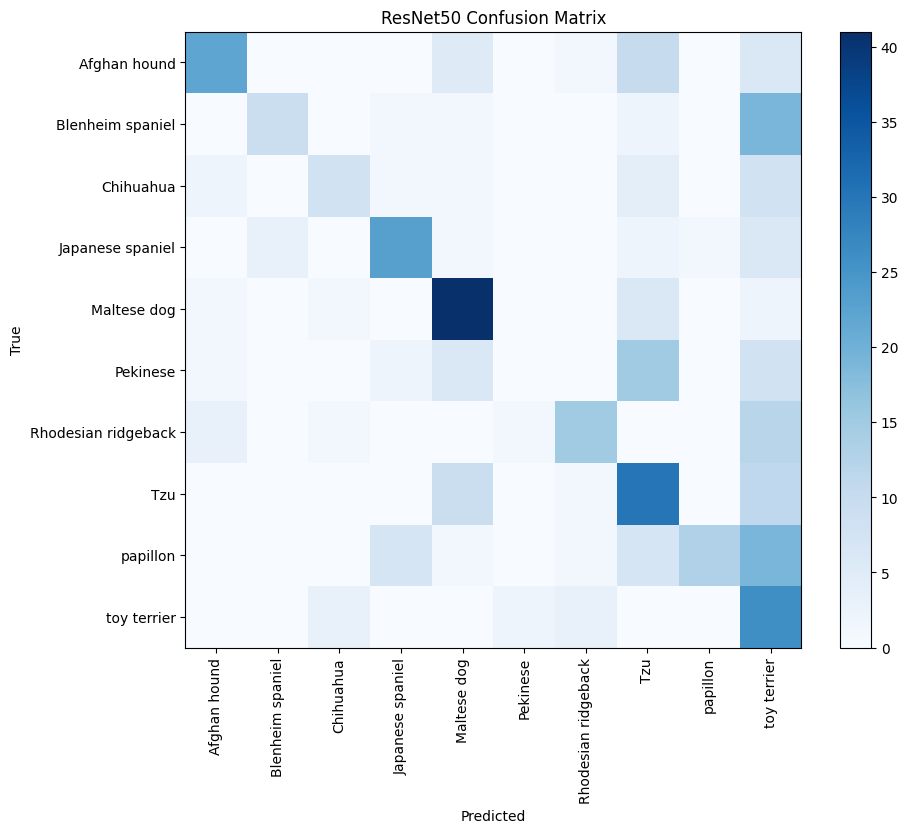

ResNet50 confusion matrix plotted.


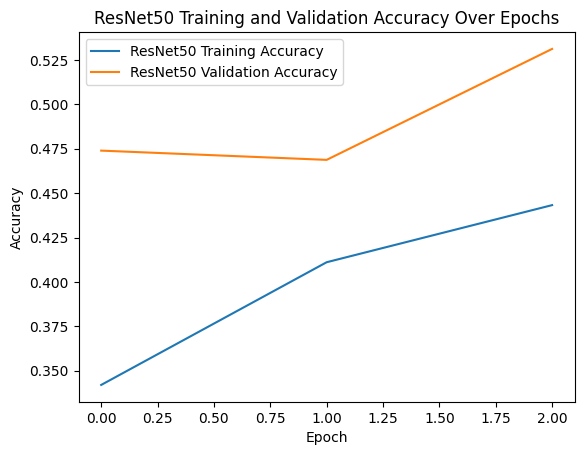

ResNet50 training history plotted.


In [ ]:

# Step 10: Plots the confusion matrix for the ResNet50 model. It displays the matrix as a heatmap, with breed labels on both axes. The plot is then shown, and a message indicating the completion of plotting is printed
import matplotlib.pyplot as plt

# Plot confusion matrix for the ResNet50 model
plt.figure(figsize=(10, 8))
plt.imshow(resnet_conf_matrix, cmap=plt.cm.Blues)
plt.title('ResNet50 Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(len(breed_names)), breed_names, rotation=90)
plt.yticks(np.arange(len(breed_names)), breed_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Output statement
print("ResNet50 confusion matrix plotted.")

# -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Step 11: Plots  the training and validation accuracy over epochs for the ResNet50 model. The plot displays the training accuracy and validation accuracy against the number of epochs. Finally, it prints a message indicating the completion of plotting
# Plot training history for the ResNet50 model
plt.plot(resnet_history.history['accuracy'], label='ResNet50 Training Accuracy')
plt.plot(resnet_history.history['val_accuracy'], label='ResNet50 Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('ResNet50 Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

# Output statement
print("ResNet50 training history plotted.")


In [ ]:

# Step 12: Load the pre-trained VGG16 model without the fully connected layers, add custom fully connected layers, and compile the model
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy


# Model 2: VGG16
# Load the pre-trained VGG16 model without the top (fully connected) layers
vgg_base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
vgg_base_model.trainable = False

# Define the VGG16 model architecture
vgg_model = Sequential([
    vgg_base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the VGG16 model
vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Output statement
print("VGG16 model architecture defined.")


58889256/58889256 [==============================] - 2s 0us/step
VGG16 model architecture defined.


In [ ]:

# Step 13: Train the VGG16 model using the fit method, specifying training and validation data, number of epochs, and steps per epoch. Print a statement indicating completion of VGG16 model training
# a: Train the VGG16 model
vgg_history = vgg_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=3,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size
)

# Output statement
print("VGG16 model training completed.")


Epoch 1/3
35/35 [==============================] - 1003s 29s/step - loss: 4.6354 - accuracy: 0.4397 - val_loss: 1.7345 - val_accuracy: 0.3984
Epoch 2/3
35/35 [==============================] - 961s 28s/step - loss: 1.9912 - accuracy: 0.4370 - val_loss: 1.7309 - val_accuracy: 0.4453
Epoch 3/3
35/35 [==============================] - 1000s 29s/step - loss: 1.6984 - accuracy: 0.4772 - val_loss: 1.6064 - val_accuracy: 0.4844
VGG16 model training completed.


In [ ]:

# Step 14: Evaluate the VGG16 model on the test set using the evaluate method and print the test accuracy. Print a statement indicating completion of VGG16 model evaluation
# b: Evaluate the VGG16 model on the test set
vgg_test_loss, vgg_test_accuracy = vgg_model.evaluate(test_generator)
print(f'VGG16 Test Accuracy: {vgg_test_accuracy}')

# Output statement
print("VGG16 model evaluation completed.")


12/12 [==============================] - 241s 20s/step - loss: 1.8756 - accuracy: 0.4036
VGG16 Test Accuracy: 0.4036458432674408
VGG16 model evaluation completed.


12/12 [==============================] - 241s 20s/step


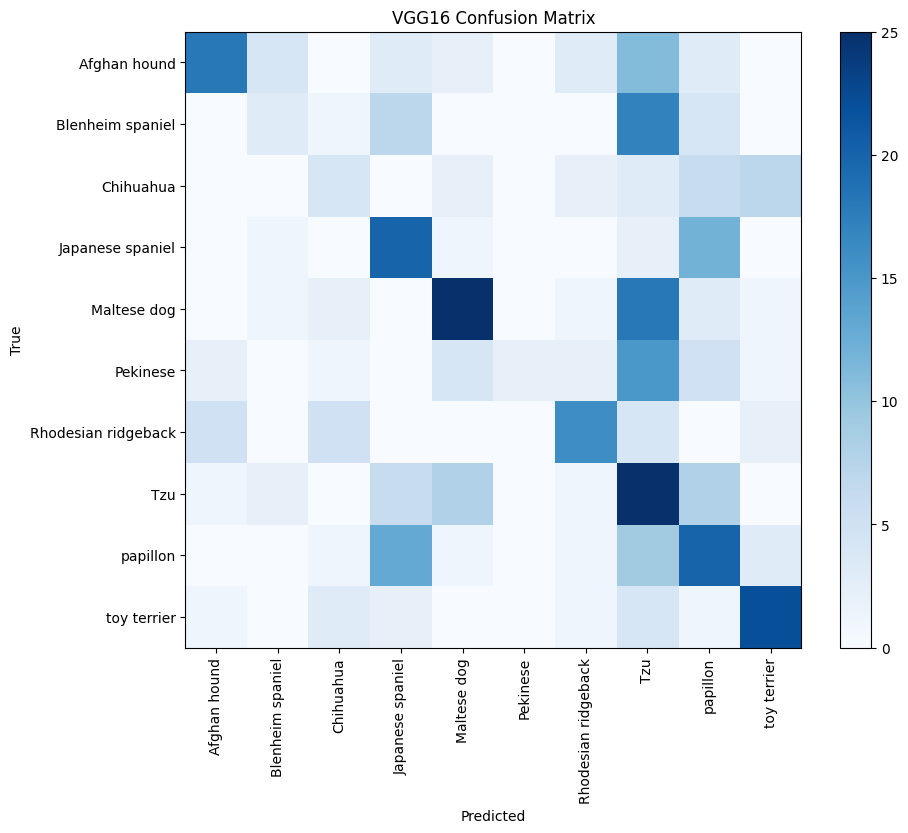

VGG16 confusion matrix plotted.


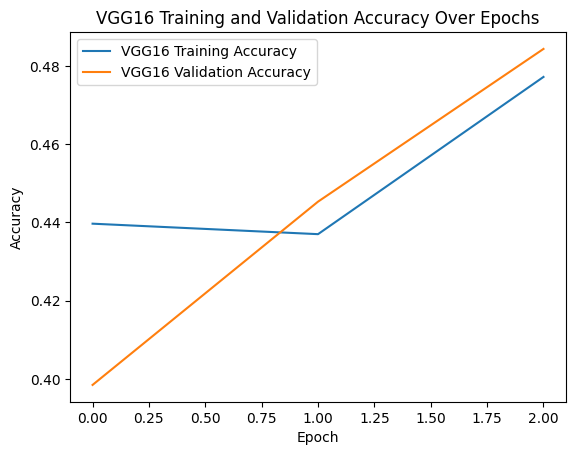

VGG16 training history plotted.


In [ ]:

# Step 15: Generate the confusion matrix for the VGG16 model's predictions on the test set and plot it. Print statements indicating completion of confusion matrix plotting and training history plotting for VGG16
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate confusion matrix for VGG16
vgg_y_pred = vgg_model.predict(test_generator)
vgg_y_pred_classes = np.argmax(vgg_y_pred, axis=1)
vgg_conf_matrix = confusion_matrix(test_generator.classes, vgg_y_pred_classes)

# Plot confusion matrix for VGG16
plt.figure(figsize=(10, 8))
plt.imshow(vgg_conf_matrix, cmap=plt.cm.Blues)
plt.title('VGG16 Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(len(breed_names)), breed_names, rotation=90)
plt.yticks(np.arange(len(breed_names)), breed_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Output statement
print("VGG16 confusion matrix plotted.")

# ------------------------------------------------------------------------------------

# Step 16: Plot the training and validation accuracy over epochs for the VGG16 model.
# Plot training history for VGG16 model
plt.plot(vgg_history.history['accuracy'], label='VGG16 Training Accuracy')
plt.plot(vgg_history.history['val_accuracy'], label='VGG16 Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('VGG16 Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

# Output statement
print("VGG16 training history plotted.")


In [ ]:

# Step 17
from sklearn.neighbors import KNeighborsClassifier
import cv2
import numpy as np

# Model 3: KNN
# Initialize and train the KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)

# Resize images to a common size (e.g., 100x100)
image_size = (100, 100)

# Resize and flatten the images
knn_X_train_resized = np.array([cv2.resize(cv2.imread(image_path), image_size) for image_path in X_train])
knn_X_train_flattened = knn_X_train_resized.reshape(knn_X_train_resized.shape[0], -1)

# Train the classifier
knn_classifier.fit(knn_X_train_flattened, y_train)

# Output statement
print("KNN classifier training completed.")

KNN classifier training completed.


In [ ]:

# Step 18
import cv2
import numpy as np

# Resize test images to a common size
image_size = (100, 100)

# Resize and flatten the test images
knn_X_test_resized = np.array([cv2.resize(cv2.imread(image_path), image_size) for image_path in X_test])
knn_X_test_flattened = knn_X_test_resized.reshape(knn_X_test_resized.shape[0], -1)

# Predict using the KNN classifier on the resized test set
knn_y_pred = knn_classifier.predict(knn_X_test_flattened)

# Evaluate the KNN classifier
knn_accuracy = np.mean(knn_y_pred == y_test)
print(f'KNN Test Accuracy: {knn_accuracy}')

# Output statement
print("KNN classifier evaluation completed.")

KNN Test Accuracy: 0.18489583333333334
KNN classifier evaluation completed.


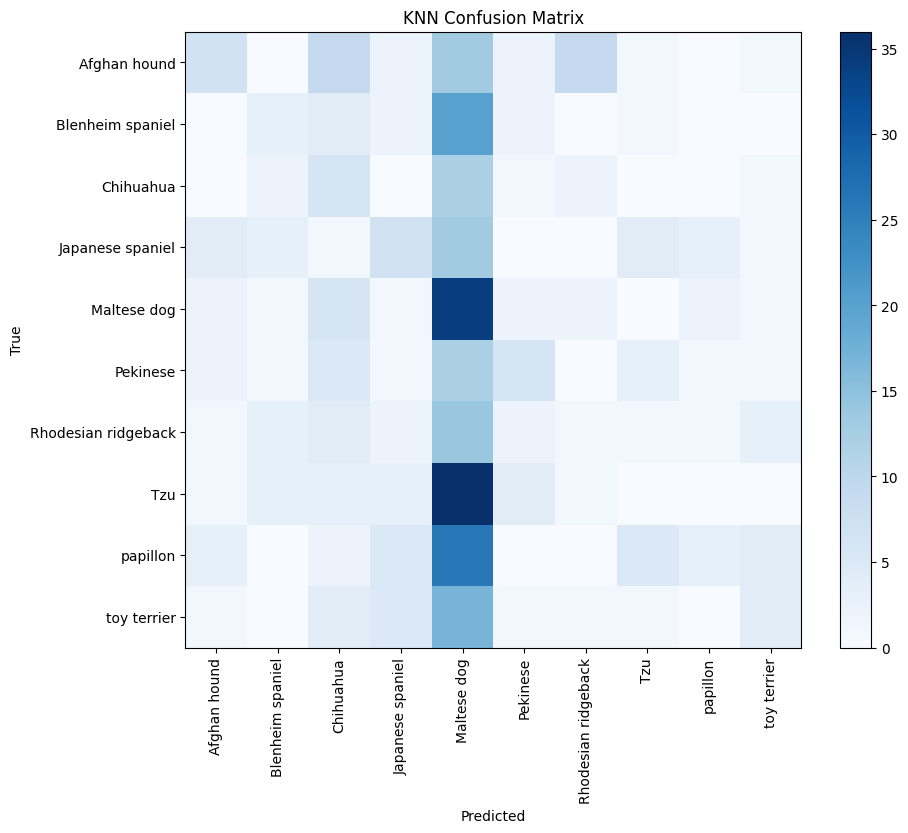

KNN confusion matrix plotted.


In [ ]:

# Step 19: Generate the confusion matrix for the KNN classifier's predictions on the test set and plot it. Print a statement indicating completion of confusion matrix plotting for KNN
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Generate confusion matrix for KNN
knn_conf_matrix = confusion_matrix(y_test, knn_y_pred)

# Plot confusion matrix for KNN
plt.figure(figsize=(10, 8))
plt.imshow(knn_conf_matrix, cmap=plt.cm.Blues)
plt.title('KNN Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(len(breed_names)), breed_names, rotation=90)
plt.yticks(np.arange(len(breed_names)), breed_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Output statement
print("KNN confusion matrix plotted.")


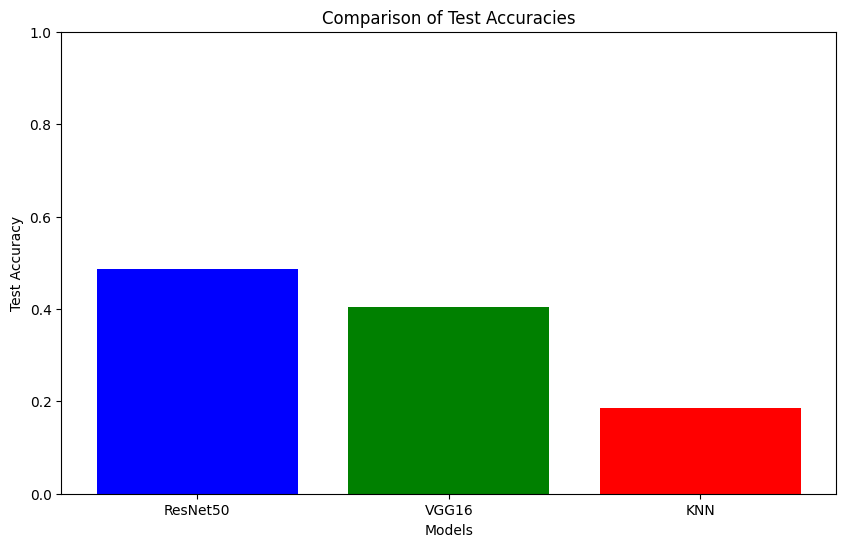

Graph comparing the accuracies of all three models plotted.


In [ ]:

# Step 20: Plot a bar graph comparing the test accuracies of three models: ResNet50, VGG16, and KNN. Print a statement indicating completion of the graph plotting
import matplotlib.pyplot as plt

# Plot a graph comparing the accuracy of all three models
models = ['ResNet50', 'VGG16', 'KNN']
accuracies = [resnet_test_accuracy, vgg_test_accuracy, knn_accuracy]

plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'red'])
plt.xlabel('Models')
plt.ylabel('Test Accuracy')
plt.title('Comparison of Test Accuracies')
plt.ylim(0, 1)
plt.show()

# Output statement
print("Graph comparing the accuracies of all three models plotted.")
